## Importing Necessary Libraries

In [202]:
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
sns.set()
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd

In [203]:
# Root url of IPL website
years = np.arange(2008,2021)
base = 'https://www.iplt20.com/matches/results/men/'

In [204]:
# Get the match_no, time and stadium
def process(match):
    text = match.get_text()
    ls = text.strip().split(' ')
    ist_index = ls.index('IST')
    return ' '.join(ls[:ist_index-1]),ls[ist_index-1],' '.join(ls[ist_index+3:])

# Extracts the ipl_data of specified year
def get_data(ipl_data,year):
    data = ipl_data.find(class_ = 'js-list')
    matches = data.find_all(class_ = 'js-match')
    year_data = []
    for match in matches:
        win_val = match.find(class_ = "result__outcome u-hide-phablet").get_text().split(' ')
        try:
            win = ' '.join(win_val[:win_val.index('won')])
        except:
            continue
        match_no,time,stadium = process(match.find(class_ = "result__info u-hide-phablet"))
        result = match.find_all(class_ = 'result__team')
        # Abandoned matches
        try:
            score = re.findall("[0-9]+/?[0-9]+",result[0].find(class_ = 'result__score').get_text())
            t1_score = score[0]
            t1_overs = '.'.join(score[1:])
        except:
            continue
        t1 = result[0].find(class_ = 'result__team-name').get_text()
        t2 = result[1].find(class_ = 'result__team-name').get_text()
        score = re.findall("[0-9]+/?[0-9]+",result[1].find(class_ = 'result__score').get_text())
        t2_score = score[0]
        t2_overs = '.'.join(score[1:])
        year_data.append(
        {
        "Year" : year,
        "Match_Number" : match_no,
        "Time" : time,
        "Stadium" : stadium,
        "Team1" : t1,
         "Team1_score" : t1_score,
         "Team1_Overs_Played" : t1_overs,
         "Team2" : t2,
         "Team2_score" : t2_score,
        "Team2_Overs_Played" : t2_overs,
         "Win_team" : win
        })
    return year_data

## Extracting the IPL data between 2008-2020

In [205]:
final_data = []
for year in years:
    ipl = requests.get(base+str(year))
    ipl_data = bs(ipl.content,'html.parser')
    year_data = get_data(ipl_data,year)
    final_data.extend(year_data)
final_df = pd.DataFrame(final_data)

In [206]:
final_df.head()

,Year,Match_Number,Time,Stadium,Team1,Team1_score,Team1_Overs_Played,Team2,Team2_score,Team2_Overs_Played,Win_team
0,2008,Final,20:00,"DY Patil Stadium, Navi Mumbai",Chennai Super Kings,163/5,20/20,Rajasthan Royals,164/7,20/20,Rajasthan Royals
1,2008,2nd Semi-Final,20:00,"Wankhede Stadium, Mumbai",Chennai Super Kings,116/1,14.5/20,Punjab Kings,112/8,20/20,Chennai Super Kings
2,2008,1st Semi-Final,20:00,"Wankhede Stadium, Mumbai",Delhi Capitals,87,16.1/20,Rajasthan Royals,192/9,20/20,Rajasthan Royals
3,2008,Match 56,20:00,"IS Bindra Stadium, Mohali",Punjab Kings,221/3,20/20,Rajasthan Royals,180/7,20/20,Punjab Kings
4,2008,Match 55,16:00,"M. Chinnaswamy Stadium, Bengaluru",Royal Challengers Bangalore,122/9,18/20,Mumbai Indians,126/1,16/20,Mumbai Indians


In [207]:
final_df.shape

(812, 11)

In [208]:
final_df.isna().sum()

Year                  0
Match_Number          0
Time                  0
Stadium               0
Team1                 0
Team1_score           0
Team1_Overs_Played    0
Team2                 0
Team2_score           0
Team2_Overs_Played    0
Win_team              0
dtype: int64

In [209]:
# Correcting the team names
def correct_team_name(x):
    if(x=='DD' or x=='Delhi Daredevils'):
        return 'Delhi Capitals'
    elif(x=='CSK'):
        return 'Chennai Super Kings'
    elif(x=='Kings XI Punjab'):
        return 'Punjab Kings'
    elif(x=='KKR'):
        return 'Kolkata Knight Riders'
    elif(x=='Rising Pune Supergiants'):
        return 'Rising Pune Supergiant'
    elif(x=='RCB'):
        return 'Royal Challengers Bangalore'
    elif(x=='Royals'):
        return 'Rajasthan Royals'
    elif(x=='KTK'):
        return 'Kochi Tuskers Kerala'
    elif(x.split(' ')[0] == 'Match'):
        return ' '.join(x.split(' ')[2:])[1:]
    return x
final_df['Win_team'] = final_df['Win_team'].apply(correct_team_name)

In [210]:
# Extracting Stadium name
def get_stadium(x):
    lst = x.split(' ') 
    if(lst[0][0] == '1'):
        return ' '.join(lst[2:])
    return x
final_df['Stadium'] = final_df['Stadium'].apply(get_stadium) 

## Saving the data

In [ ]:
final_df.to_csv('ipl_data.csv')

## Total matches won by each individual team till date

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

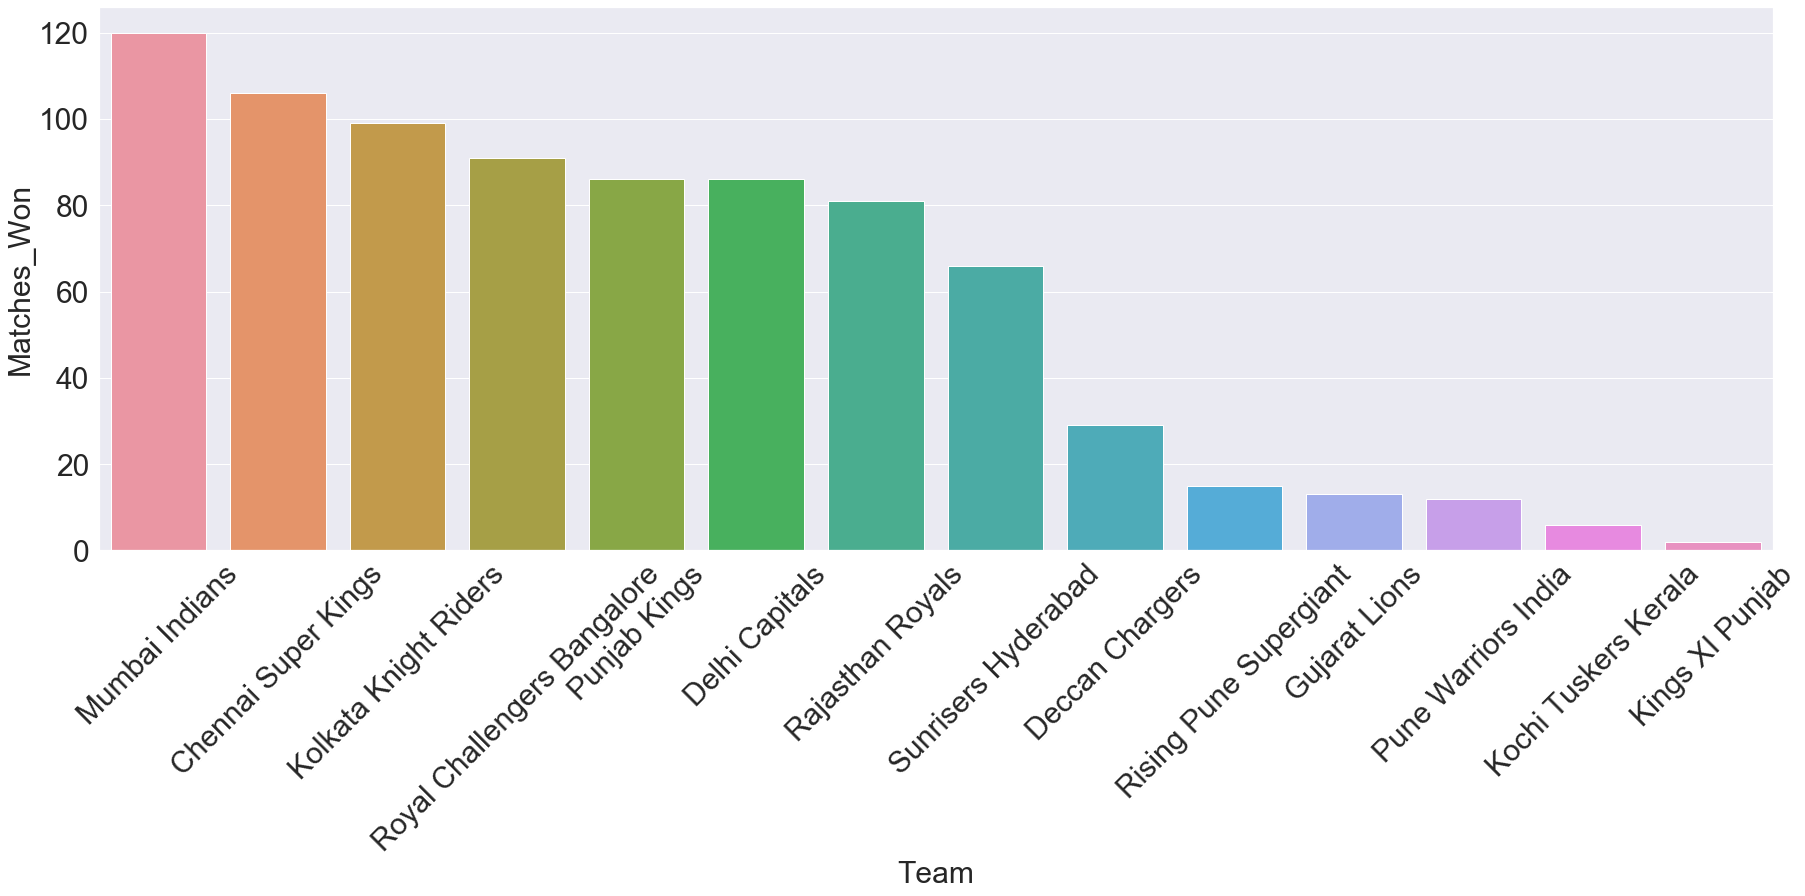

In [211]:
fig = plt.figure(figsize=(30,10))
sns.countplot(data = final_df,x = 'Win_team', order = final_df['Win_team'].value_counts().index)

plt.xticks(rotation=45)
plt.xlabel('Team',fontsize=30)
plt.ylabel('Matches_Won',fontsize=30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30,rotation = 45)

## Total titles won by each team

(array([0., 1., 2., 3., 4., 5., 6.]), <a list of 7 Text xticklabel objects>)

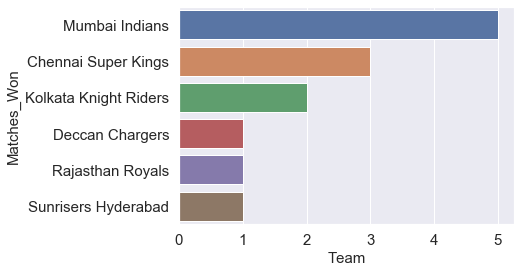

In [212]:
df = pd.DataFrame(final_df[final_df['Match_Number']=='Final'].groupby('Win_team')['Win_team'].count())
df.columns = ['Titles_won']
df = df.sort_values(by=['Titles_won'],ascending = False)
sns.barplot(data = df,y = df.index, x = df['Titles_won'])

plt.xlabel('Team',fontsize=15)
plt.ylabel('Matches_Won',fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

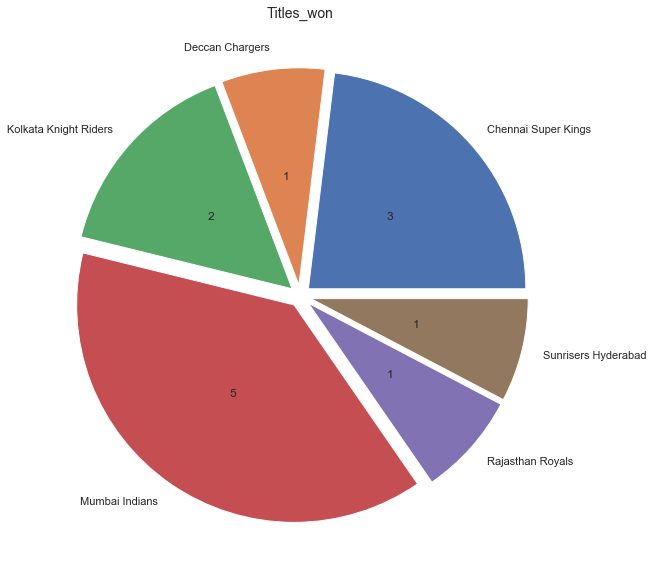

In [213]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return val
    return my_autopct
fig = plt.figure(figsize=(30,10))
data = final_df[final_df['Match_Number']=='Final'].groupby('Win_team')['Win_team'].count()
patches, texts, autotexts = plt.pie(x = data,autopct = make_autopct(data.values),explode=[0.05]*data.shape[0], labels=data.index, pctdistance=0.5)

plt.title("Titles_won", fontsize=14);

## Total matches played by each individual team

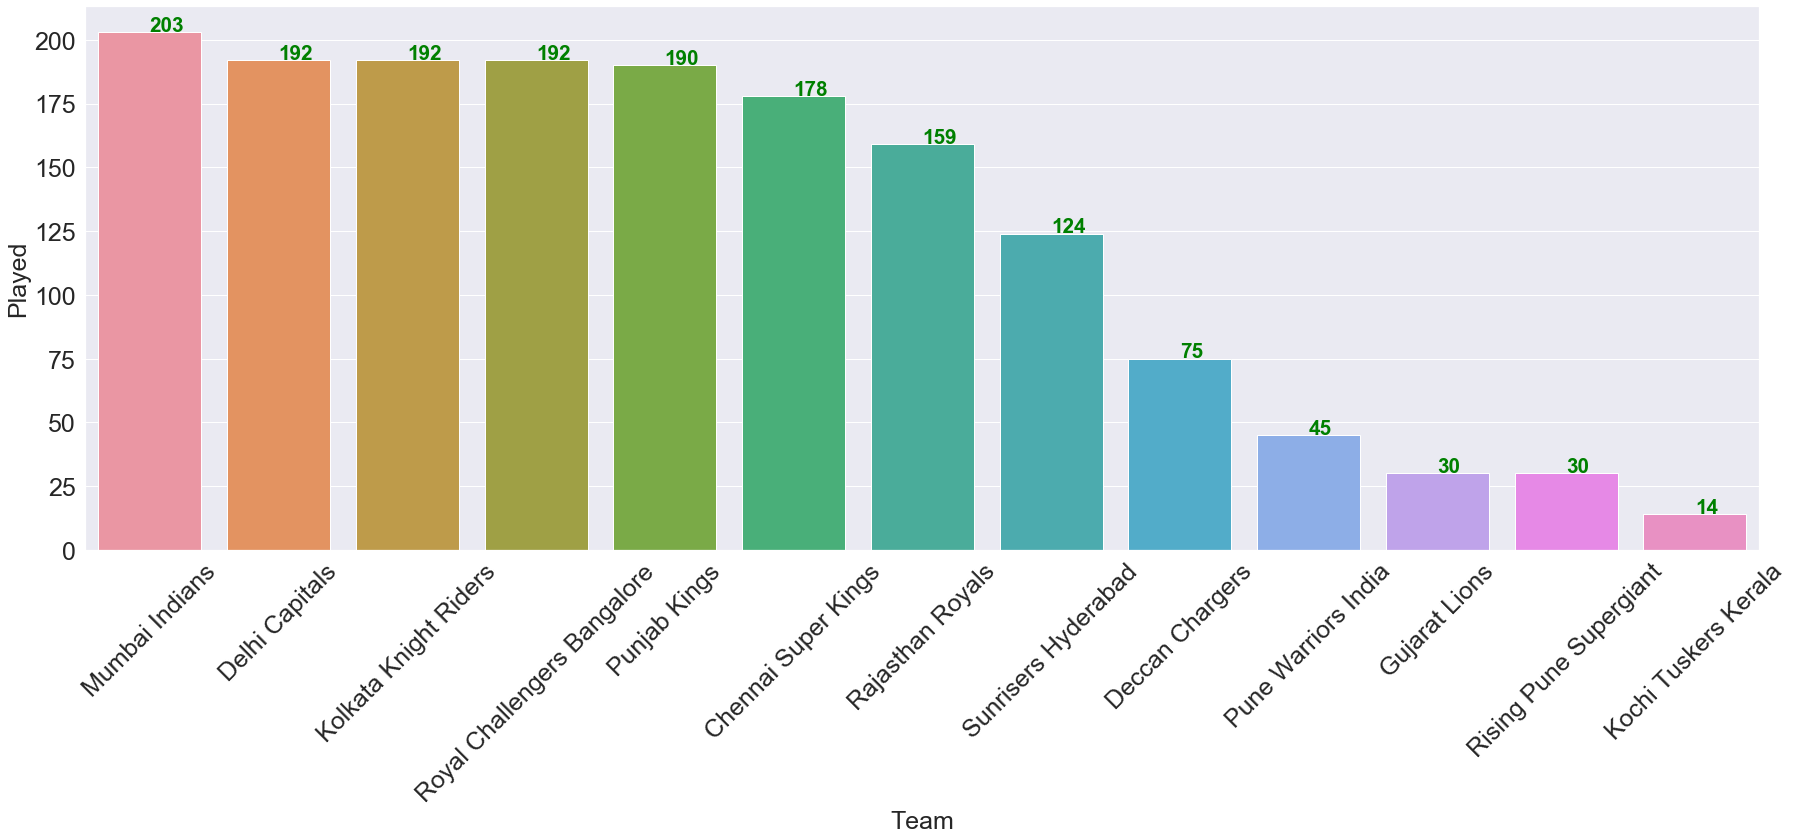

In [214]:
fig = plt.figure(figsize=(30,10))
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15

df = pd.DataFrame(pd.concat([final_df['Team1'],final_df['Team2']],axis = 0),columns = ['Team'])
df = pd.DataFrame(df.groupby('Team')['Team'].count())
df.columns = ['Played']
df = df.sort_values(by=['Played'],ascending = False)
sns.barplot(data = df,x = df.index, y = df['Played'])
plt.xticks(rotation=45)
plt.xlabel('Team',fontsize = 25)
plt.ylabel('Played',fontsize = 25)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25,rotation = 45)

for i, v in enumerate(df['Played']):
    plt.text(i,v+0.5, str(v), color='green', fontweight='bold',size = 'xx-large')

## Number of wins and loses of each team

In [215]:
df1 = pd.DataFrame(pd.concat([final_df['Team1'],final_df['Team2']],axis = 0),columns = ['Team'])
df2 = pd.DataFrame(pd.concat([final_df['Win_team'],final_df['Win_team']],axis = 0))
df = pd.concat([df1,df2],axis = 1)
df.head()

,Team,Win_team
0,Chennai Super Kings,Rajasthan Royals
1,Chennai Super Kings,Chennai Super Kings
2,Delhi Capitals,Rajasthan Royals
3,Punjab Kings,Punjab Kings
4,Royal Challengers Bangalore,Mumbai Indians


In [216]:
# Evaluating Win or Loss
def evaluate(row):
    #print(row[0],row[1])
    if(row[0]==row[1]):
        row[1] = 'Won'
    else:
        row[1] = 'Lost'
    return row
t_df = df.apply(evaluate,axis = 1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

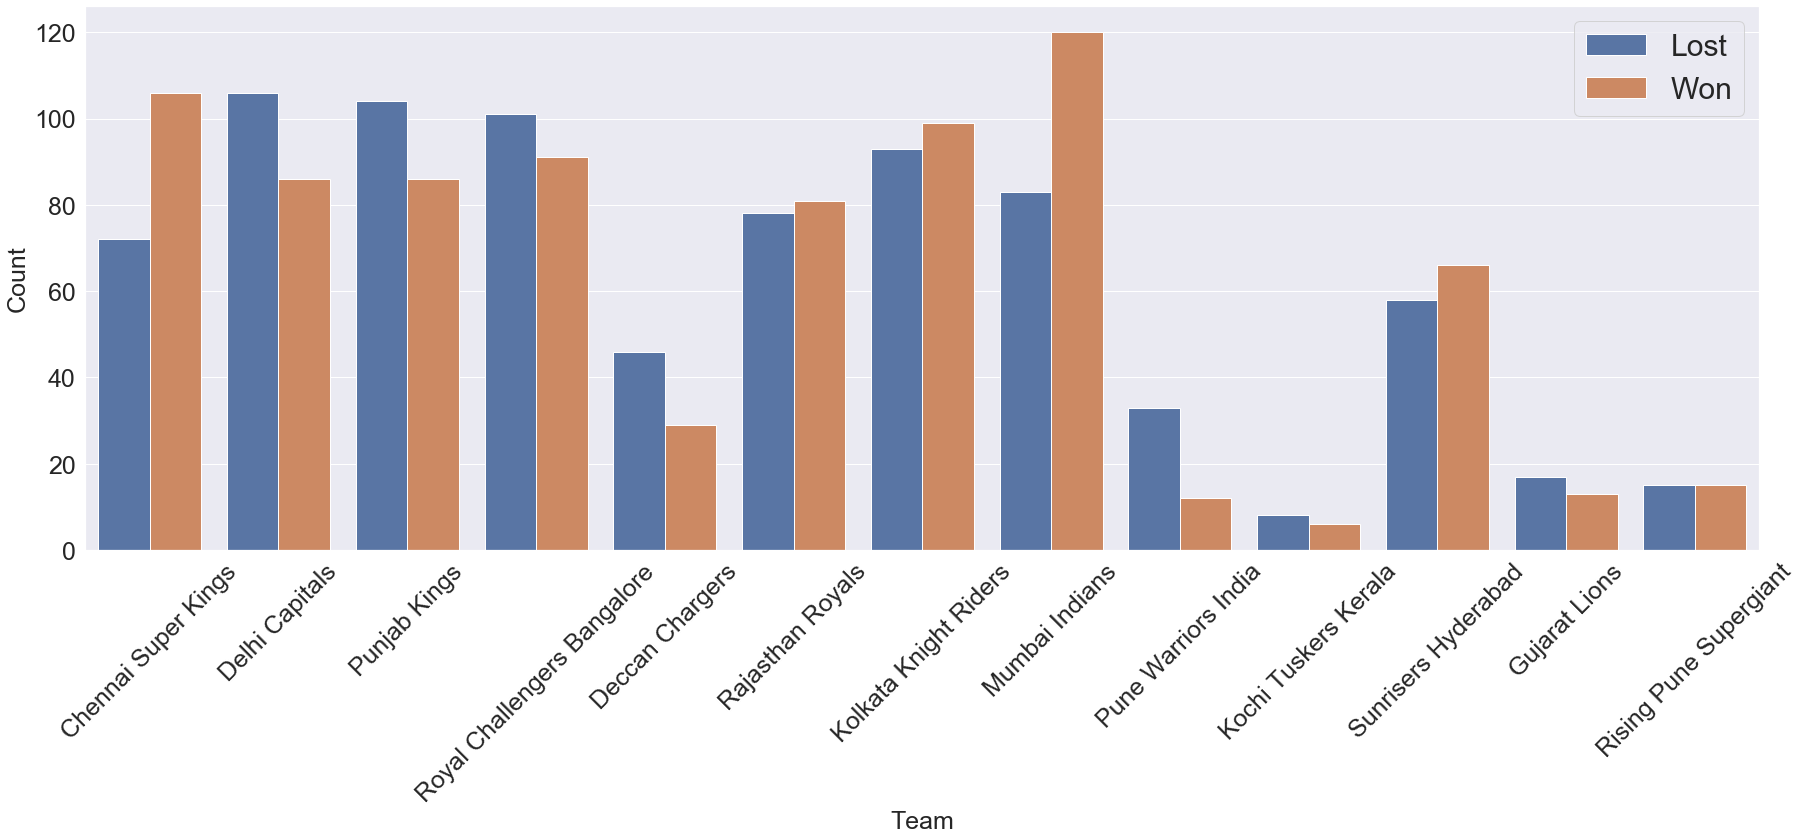

In [217]:
# Number of Wins and Loses overall all years
fig = plt.figure(figsize=(30,10))
sns.countplot(data = t_df,x = 'Team',hue = 'Win_team')

plt.xlabel('Team', fontsize=25)
plt.ylabel('Count', fontsize=25)
plt.legend(fontsize = 30)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25,rotation = 45)

## Success Rate of each team

In [218]:
# Number of Wins and Losses of each Team
df1 = pd.DataFrame(df.groupby(['Team','Win_team'])['Win_team'].count())
df2 = pd.DataFrame(columns = ['Team','Won','Lost'])
df1.head()

Win_team
Team                Win_team          
Chennai Super Kings Lost            72
                    Won            106
Deccan Chargers     Lost            46
                    Won             29
Delhi Capitals      Lost           106

In [219]:
lst = list(zip(list(df1.index),df1.values))
for i in range(0,len(lst),2):
    
    # Inserting row to dataframe
    df2.loc[-1] = [lst[i][0][0],lst[i+1][1][0],lst[i][1][0]]
    df2.index = df2.index + 1  # shifting index
    df2 = df2.sort_index()
df2.head()

,Team,Won,Lost
0,Sunrisers Hyderabad,66,58
1,Royal Challengers Bangalore,91,101
2,Rising Pune Supergiant,15,15
3,Rajasthan Royals,81,78
4,Punjab Kings,86,104


In [220]:
# Success Rate of each team
def success_rate(x):
    return x[1]/(x[1]+x[2])*100
df2['Success_Rate'] = df2.apply(success_rate,axis = 1)

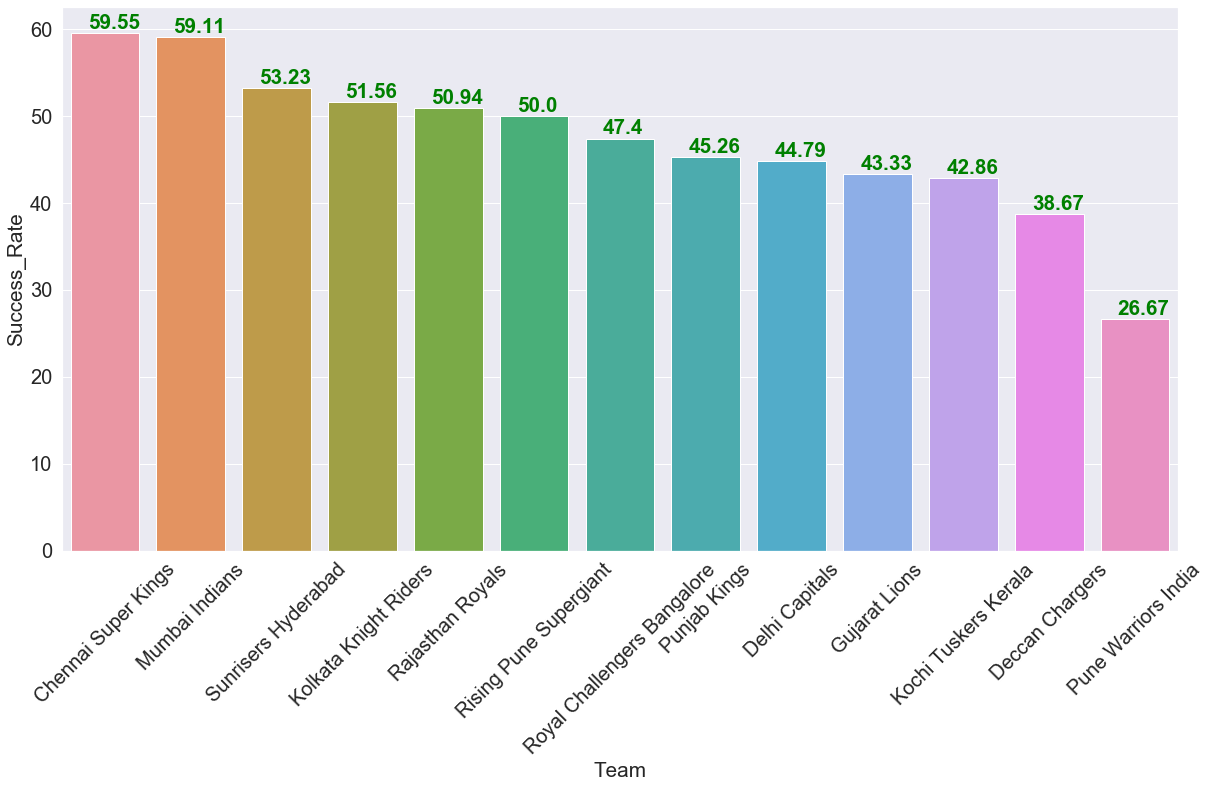

In [221]:
# SUccess rate of each team over all years
df2 = df2.sort_values(by = 'Success_Rate', ascending = False)
fig = plt.figure(figsize=(20,10))
sns.barplot(data = df2,x = 'Team', y = 'Success_Rate')
plt.xlabel('Team', size = 'xx-large')
plt.ylabel('Success_Rate', size = 'xx-large')
plt.xticks(rotation = 45)
plt.xticks(fontsize = 20)

for i, v in enumerate(df2['Success_Rate']):
    plt.text(i-0.2,v+0.5, str(round(v,2)), color='green', fontweight='bold',size = 'xx-large')

## Team performance in Home vs Away 

In [222]:
df1 = pd.DataFrame(pd.concat([final_df['Team1'],final_df['Team2']],axis = 0),columns = ['Team'])
df2 = pd.DataFrame(pd.concat([final_df['Win_team'],final_df['Win_team']],axis = 0))
df3 = pd.DataFrame(pd.concat([final_df['Stadium'],final_df['Stadium']],axis = 0))
df = pd.concat([df1,df2,df3],axis = 1)
df.head()

,Team,Win_team,Stadium
0,Chennai Super Kings,Rajasthan Royals,"DY Patil Stadium, Navi Mumbai"
1,Chennai Super Kings,Chennai Super Kings,"Wankhede Stadium, Mumbai"
2,Delhi Capitals,Rajasthan Royals,"Wankhede Stadium, Mumbai"
3,Punjab Kings,Punjab Kings,"IS Bindra Stadium, Mohali"
4,Royal Challengers Bangalore,Mumbai Indians,"M. Chinnaswamy Stadium, Bengaluru"


In [223]:
def find_win(row):
    if(row[0]==row[1]):
        return 1
    else:
        return 0
    return row
def find_lose(row):
    if(row[0]==row[1]):
        return 0
    else:
        return 1
    return row

df['Win'] = df.apply(find_win,axis = 1)
df['Lose'] = df.apply(find_lose,axis = 1)

df.head()

,Team,Win_team,Stadium,Win,Lose
0,Chennai Super Kings,Rajasthan Royals,"DY Patil Stadium, Navi Mumbai",0,1
1,Chennai Super Kings,Chennai Super Kings,"Wankhede Stadium, Mumbai",1,0
2,Delhi Capitals,Rajasthan Royals,"Wankhede Stadium, Mumbai",0,1
3,Punjab Kings,Punjab Kings,"IS Bindra Stadium, Mohali",1,0
4,Royal Challengers Bangalore,Mumbai Indians,"M. Chinnaswamy Stadium, Bengaluru",0,1


In [224]:
# Number of Wins,Losses and Success Rate of each team at each stadium
df1 = pd.DataFrame(df.groupby(['Team','Stadium'],as_index = False)['Win','Lose'].sum())
def success_rate(x):
    return round(x[2]/(x[2]+x[3])*100,2)
def total(x):
    return x[2]+x[3]
df1['Success_Rate'] = df1.apply(success_rate, axis = 1)
df1['Total'] = df1.apply(total, axis = 1)
df1 = df1.sort_values(by = 'Success_Rate',ascending = False)
df1.head()

c:\users\manikanta\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Team,Stadium,Win,Lose,Success_Rate,Total
0,Chennai Super Kings,"ACA-VDCA Stadium, Visakhapatnam",2,0,100.0,2
46,Deccan Chargers,"Newlands, Cape Town",2,0,100.0,2
263,Sunrisers Hyderabad,"Green Park, Kanpur",1,0,100.0,1
85,Gujarat Lions,"IS Bindra Stadium, Mohali",2,0,100.0,2
260,Sunrisers Hyderabad,"Brabourne Stadium, Mumbai",1,0,100.0,1


In [225]:
# Finding Home ground based on Maximum matches played
teams = final_df['Team1'].unique()
team_home = {}
for team in teams:
    temp = df1[df1['Team']==team]
    team_home[team] = temp[temp['Total']==max(temp['Total'])]['Stadium'].values[0]
team_home

{'Chennai Super Kings': 'M. A. Chidambaram Stadium, Chennai',
 'Delhi Capitals': 'Arun Jaitley Stadium, Delhi',
 'Punjab Kings': 'IS Bindra Stadium, Mohali',
 'Royal Challengers Bangalore': 'M. Chinnaswamy Stadium, Bengaluru',
 'Deccan Chargers': 'Rajiv Gandhi Intl. Cricket Stadium, Hyderabad',
 'Rajasthan Royals': 'Sawai Mansingh Stadium, Jaipur',
 'Kolkata Knight Riders': 'Eden Gardens, Kolkata',
 'Mumbai Indians': 'Wankhede Stadium, Mumbai',
 'Pune Warriors India': "Maharashtra Cricket Association's International Stadium, Pune",
 'Kochi Tuskers Kerala': 'Jawaharlal Nehru Stadium, Kochi',
 'Sunrisers Hyderabad': 'Rajiv Gandhi Intl. Cricket Stadium, Hyderabad',
 'Gujarat Lions': 'Saurashtra Cricket Association Stadium, Rajkot',
 'Rising Pune Supergiant': "Maharashtra Cricket Association's International Stadium, Pune"}

In [226]:
# Success Rate at Home-ground and Away
df2 = pd.DataFrame(columns = ['Team','Home','Out-of-Home'])
for team in teams:
    temp = df1[df1['Team']==team]
    Home = temp[temp['Stadium'] == team_home[team]]['Success_Rate'].values[0]
    temp = temp[temp['Stadium']!=team_home[team]]
    out = round(sum(temp['Win'])/sum(temp['Total'])*100,2)
    df2.loc[-1] = [team,Home,out]
    df2.index = df2.index + 1  # shifting index
    df2 = df2.sort_index()
df2 = df2.sort_values(by = 'Home',ascending = False)
df2.head()

,Team,Home,Out-of-Home
12,Chennai Super Kings,71.43,54.10
2,Sunrisers Hyderabad,68.18,45.00
7,Rajasthan Royals,68.09,43.75
5,Mumbai Indians,62.69,57.35
6,Kolkata Knight Riders,60.81,45.76


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

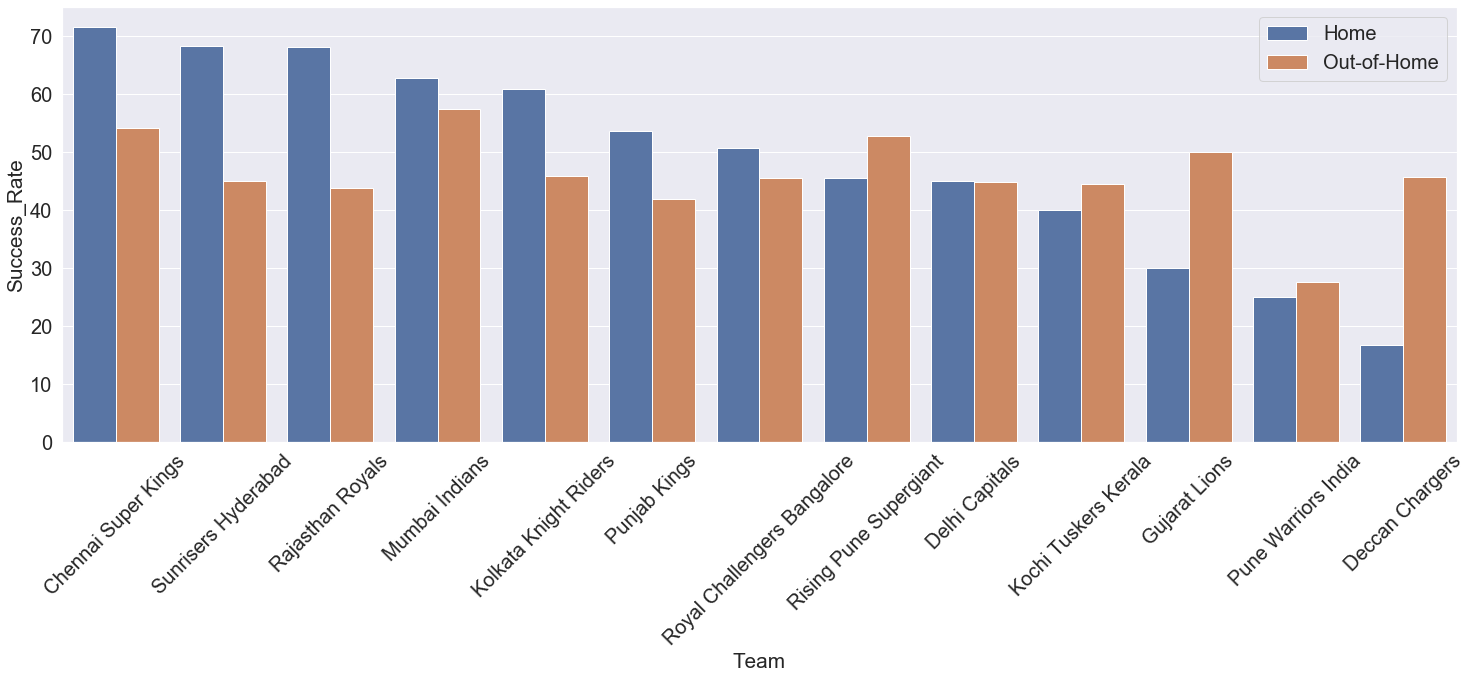

In [227]:
# Success rate at Home and Out-Of home grounds of each team
df3 = pd.melt(df2, id_vars="Team", var_name="Location", value_name="Success_Rate")
fig = plt.figure(figsize=(25,8))
sns.barplot(data = df3, x = 'Team', y = 'Success_Rate', hue = 'Location')
plt.xlabel('Team', size = 'xx-large')
plt.ylabel('Success_Rate', size = 'xx-large')
plt.legend(fontsize = 20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20,rotation = 45)

#for i, v in enumerate(df2['Success_Rate']):
#    plt.text(i-0.2,v+0.5, str(round(v,2)), color='green', fontweight='bold',size = 'xx-large')

## Min_score, Max_score and Average_score by each team

In [228]:
df1 = pd.DataFrame(pd.concat([final_df['Team1'],final_df['Team2']],axis = 0),columns = ['Team'])
df2 = pd.DataFrame(pd.concat([final_df['Team1_score'],final_df['Team2_score']],axis = 0),columns = ['Score'])
df3 = pd.DataFrame(pd.concat([final_df['Team1_Overs_Played'],final_df['Team2_Overs_Played']],axis = 0),columns = ['Overs_played'])
df4 = pd.DataFrame(pd.concat([final_df['Stadium'],final_df['Stadium']],axis = 0),columns = ['Stadium'])
df = pd.concat([df1,df2,df3,df4],axis = 1)
def get_runs(x):
    return int(x.split('/')[0])
def get_wik(x):
    try:
        return int(x.split('/')[1])
    except:
        return 10
def get_overs(x):
    return float(x.split('/')[0])
df['Runs'] = df['Score'].apply(get_runs)
df['Wickets'] = df['Score'].apply(get_wik)
df['Overs'] = df['Overs_played'].apply(get_overs)
df.head()

,Team,Score,Overs_played,Stadium,Runs,Wickets,Overs
0,Chennai Super Kings,163/5,20/20,"DY Patil Stadium, Navi Mumbai",163,5,20.0
1,Chennai Super Kings,116/1,14.5/20,"Wankhede Stadium, Mumbai",116,1,14.5
2,Delhi Capitals,87,16.1/20,"Wankhede Stadium, Mumbai",87,10,16.1
3,Punjab Kings,221/3,20/20,"IS Bindra Stadium, Mohali",221,3,20.0
4,Royal Challengers Bangalore,122/9,18/20,"M. Chinnaswamy Stadium, Bengaluru",122,9,18.0


In [229]:
ddf = df.groupby('Team',as_index = False).agg({'Runs': ['min', 'mean', 'max']})
ddf.columns = ['Team','Min_score','Mean_score','Max_score']
ddf = ddf.sort_values(by = 'Min_score')
ddf.head()

,Team,Min_score,Mean_score,Max_score
12,Sunrisers Hyderabad,44,155.903226,231
5,Kolkata Knight Riders,48,152.593750,245
11,Royal Challengers Bangalore,49,155.989583,263
0,Chennai Super Kings,51,159.011236,246
8,Punjab Kings,53,157.242105,232


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

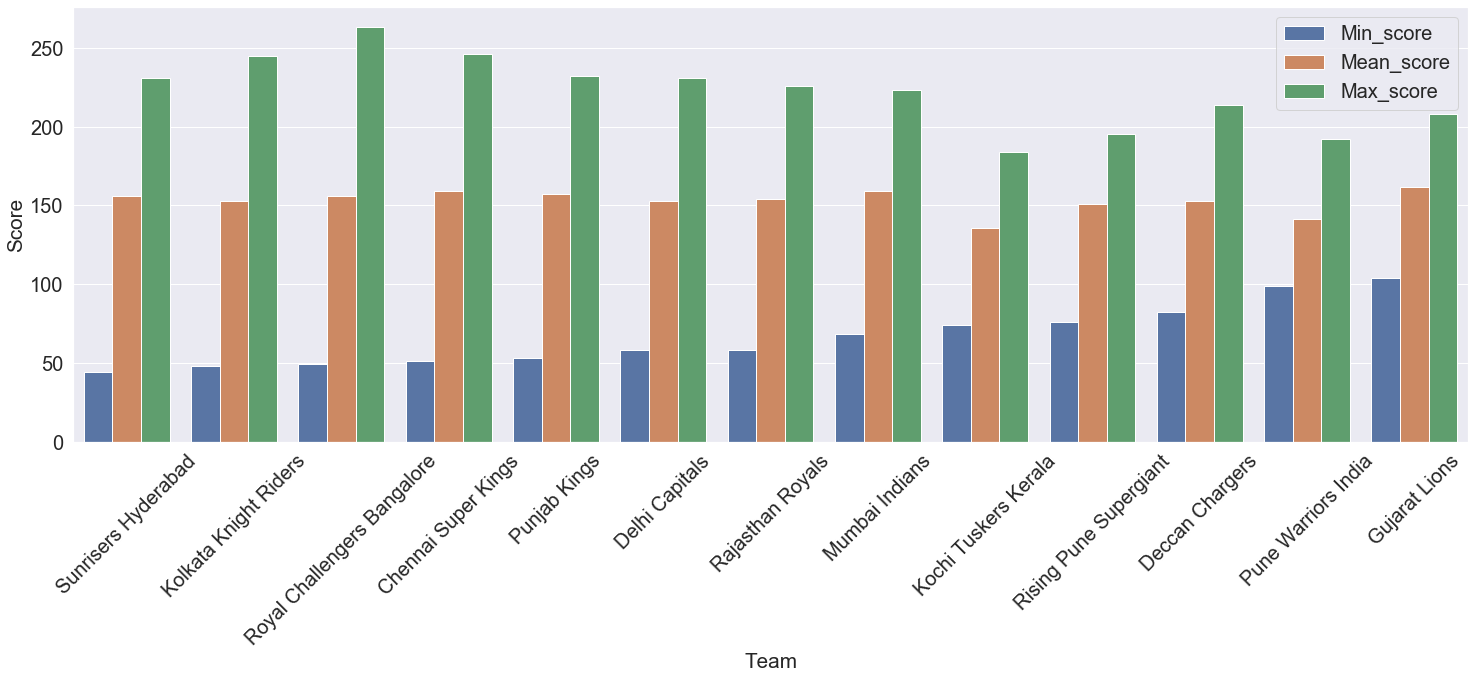

In [230]:
# Min_score, Max_Score and Avg_score of each team over all years
df3 = pd.melt(ddf, id_vars = "Team", var_name = "Category", value_name = "Score")
fig = plt.figure(figsize=(25,8))
sns.barplot(data = df3, x = 'Team', y = 'Score', hue = 'Category')

plt.xlabel('Team', size = 'xx-large')
plt.ylabel('Score', size = 'xx-large')
plt.legend(fontsize = 20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20,rotation = 45)

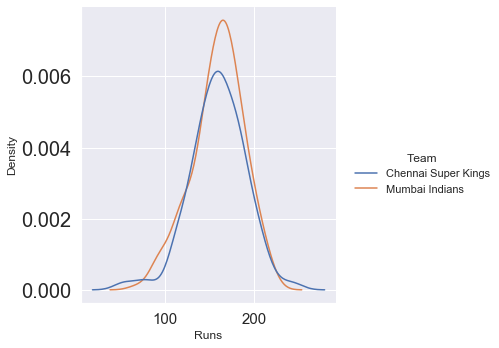

In [231]:
# PDF distribution of scores of CSK and MI
sns.displot(data = df[(df['Team'] == 'Chennai Super Kings') | (df['Team'] == 'Mumbai Indians')],x = 'Runs', hue = 'Team', kind = 'kde')

## Min_score, Max_score and Average_score at each stadium

In [232]:
ddf = df.groupby('Stadium',as_index = False).agg({'Runs': ['min', 'mean', 'max','count']})
ddf.columns = ['Stadium','Min_score','Mean_score','Max_score','Match_count']
ddf = ddf.sort_values(by = 'Match_count',ascending = False)[:10]
ddf

,Stadium,Min_score,Mean_score,Max_score,Match_count
17,"M. Chinnaswamy Stadium, Bengaluru",48,161.584416,263,154
8,"Eden Gardens, Kolkata",49,152.584416,232,154
31,"Wankhede Stadium, Mumbai",67,160.205479,235,146
1,"Arun Jaitley Stadium, Delhi",44,156.582192,231,146
23,"Rajiv Gandhi Intl. Cricket Stadium, Hyderabad",80,152.218750,231,128
16,"M. A. Chidambaram Stadium, Chennai",70,156.324561,246,114
12,"IS Bindra Stadium, Mohali",67,160.785714,240,112
25,"Sawai Mansingh Stadium, Jaipur",60,151.744681,197,94
18,Maharashtra Cricket Association's Internationa...,73,151.776316,211,76
7,"Dubai International Cricket Stadium, Dubai",109,157.606061,219,66


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

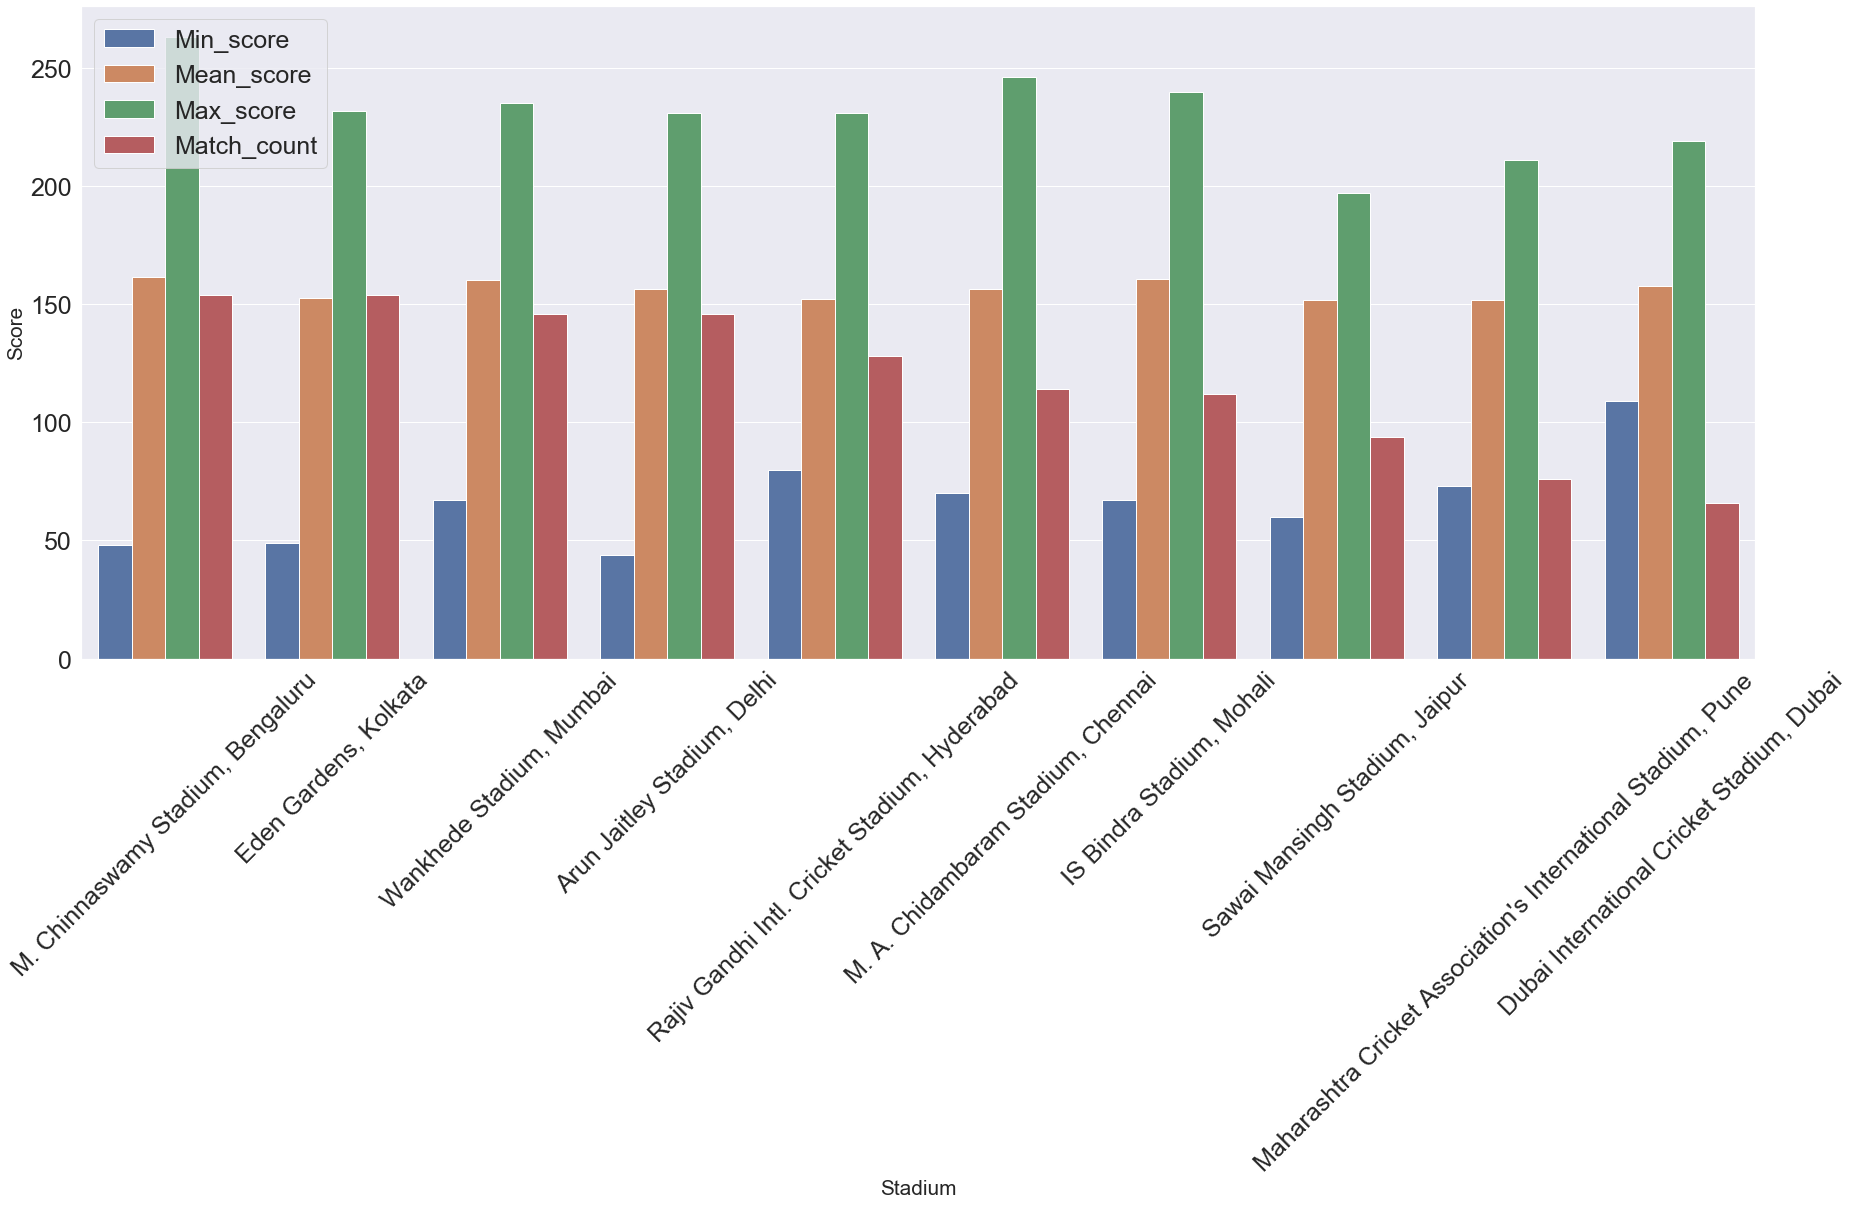

In [233]:
# Min_score, Max_Score and Avg_score at top_10 grounds over all years
df3 = pd.melt(ddf, id_vars = "Stadium", var_name = "Category", value_name = "Score")
fig = plt.figure(figsize=(30,12))
sns.barplot(data = df3, x = 'Stadium', y = 'Score', hue = 'Category')

plt.xlabel('Stadium', size = 'xx-large')
plt.ylabel('Score', size = 'xx-large')
plt.legend(fontsize = 25)
plt.yticks(fontsize= 25)
plt.xticks(fontsize=25,rotation = 45)

## Max_consecutive_Wins and Max_Consecutive_Loses of all teams in a specific year

In [234]:
year = 2008
df = final_df[final_df['Year'] == year]
df1 = pd.DataFrame(pd.concat([df['Team1'],df['Team2']],axis = 0),columns = ['Team'])
df2 = pd.DataFrame(pd.concat([df['Win_team'],df['Win_team']],axis = 0))
df3 = pd.concat([df1,df2],axis = 1)
def evaluate(row):
    #print(row[0],row[1])
    if(row[0]==row[1]):
        row[1] = 'Won'
    else:
        row[1] = 'Lost'
    return row
df = df3.apply(evaluate,axis = 1)
teams = df3['Team'].unique()
df.head()

,Team,Win_team
0,Chennai Super Kings,Lost
1,Chennai Super Kings,Won
2,Delhi Capitals,Lost
3,Punjab Kings,Won
4,Royal Challengers Bangalore,Lost


In [235]:
# Max_Cons_Wins and Max_Cons_Losses of each team in a specific year
ddf = pd.DataFrame(columns = ['Team','Max_Cons_Wins','Max_Cons_Losses'])
def get_cons_wins_and_loses(x):
    prev = -1
    prepre = -1
    win = 0
    loss = 0
    for i in range(x.shape[0]):
        if(x[i]=='Won' and prev == -1):
            prev = i
        elif(x[i] == 'Lost' and prev != -1):
            win = max(win,i-prev)
            loss = max(loss,prev-prepre-1)
            prepre = i-1
            prev = -1
    if(prev != -1):
        win = max(win,i-prev)
        loss = max(loss,prev-prepre-1)
    else:
        loss = max(loss,i-prepre-1)
    return win,loss

for team in teams:
    df1 = df[df['Team'] == team]
    wins,losses = get_cons_wins_and_loses(df1['Win_team'].values)
    ddf.loc[-1] = [team,wins,losses]
    ddf.index = ddf.index + 1
    ddf = ddf.sort_index()
ddf = ddf.sort_values(by = 'Max_Cons_Wins',ascending = False)
ddf.head()

,Team,Max_Cons_Wins,Max_Cons_Losses
2,Rajasthan Royals,9,1
5,Punjab Kings,6,3
0,Mumbai Indians,4,2
7,Chennai Super Kings,4,2
6,Delhi Capitals,3,3


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

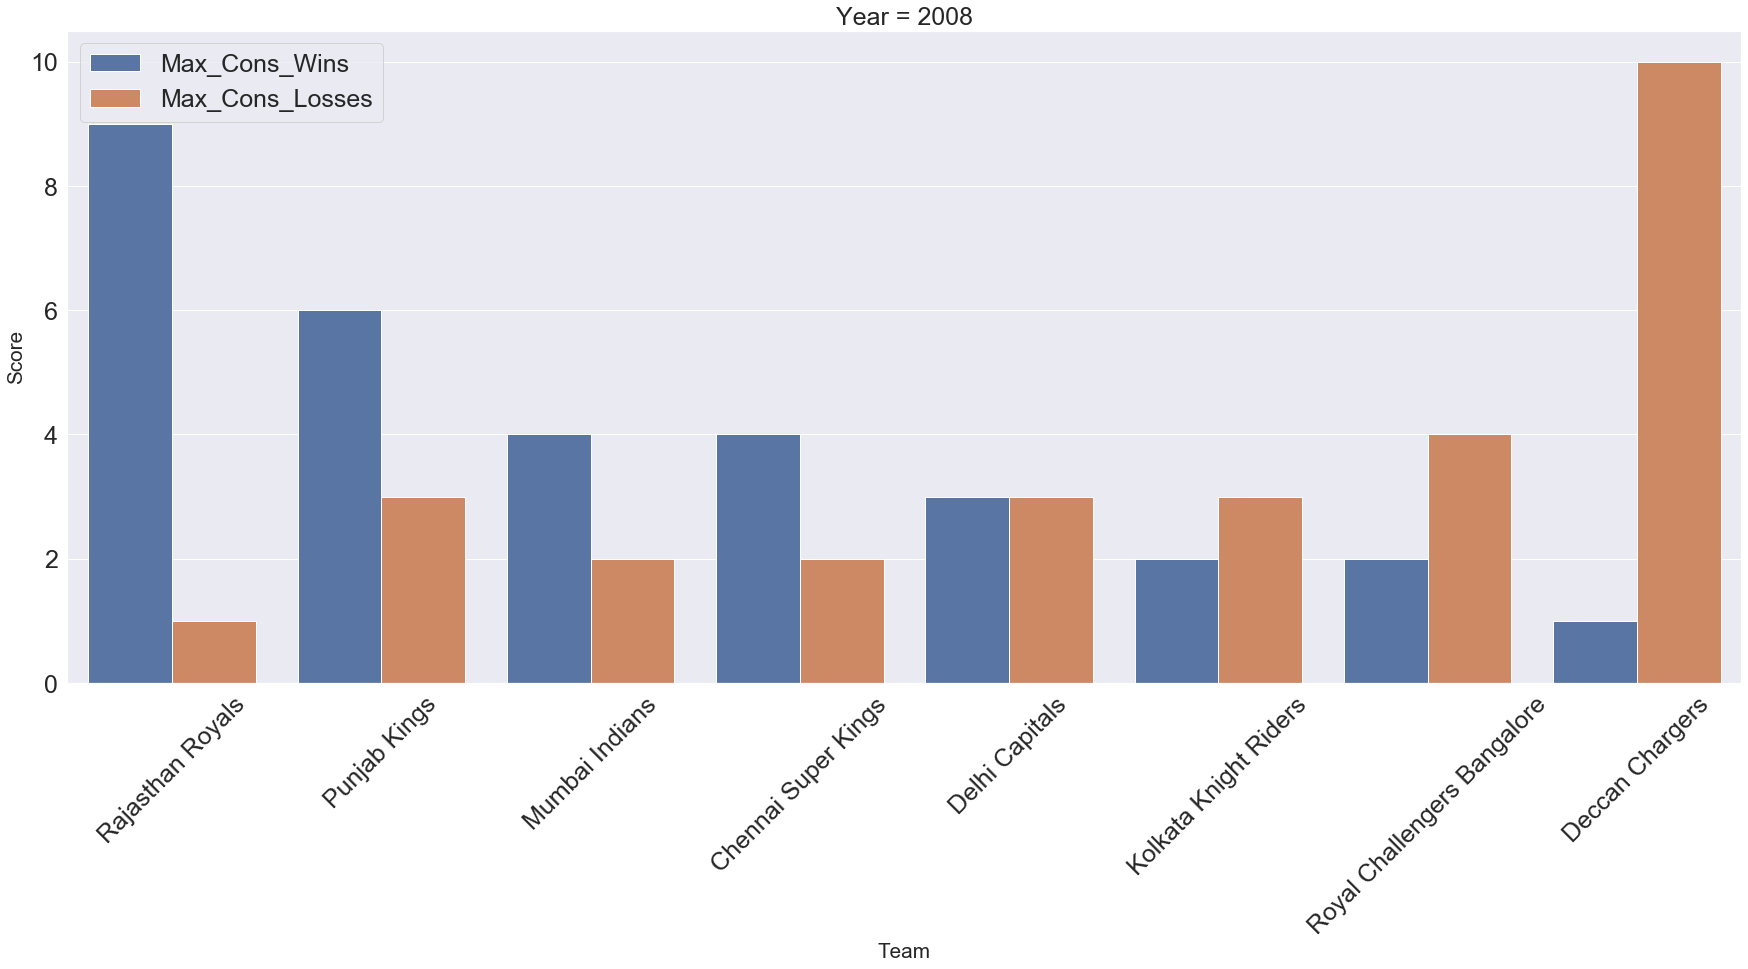

In [236]:
# Max_Consecutive_Wins and Max_Consecutive_Losses of each team in a specific year
df3 = pd.melt(ddf, id_vars = "Team", var_name = "Category", value_name = "Score")
fig = plt.figure(figsize=(30,12))
sns.barplot(data = df3, x = 'Team', y = 'Score', hue = 'Category')

plt.xlabel('Team', size = 'xx-large')
plt.ylabel('Score', size = 'xx-large')
plt.legend(fontsize = 25)
plt.yticks(fontsize= 25)
plt.title('Year = '+str(year),fontsize= 25)
plt.xticks(fontsize=25,rotation = 45)